# Fold first, ask later: structure-informed function annotation of *Pseudomonas* phage proteins
## Pipeline stage 2: annotation

### Stage 2.1: annotation - setting the stage

**Goals:**
* Assess which proteins could be annotated in absence of structure information with Pharokka.
* Compare protein( structure)s to the Phold databases, using Phold.
* Assess which proteins are ammenable to annotation based on structure similarity.
* Filter the FoldSeek files for easier function annotation.

**Requires:**
* in folder 1_dataset/a_input/protein_overview:
    * PHAGE_protein_overview.txt : a tab-seperated overview of the NCBI proteins for each PHAGE, listing NCBI unique ID, NCBI protein name and protein length, with each row representing one NCBI protein entry
* in folder 1_dataset/b_structure/
    * in folder proteins_cluster:
        *  phage_hypothetical_clustered.tsv: MMSeqs sequence-based protein clustering output file
    * in folder structure_comparison:
        * in each folder batch_XX with XX a batch number between 0 and 34:
            * PROTEIN_foldseek_af50m_default.csv and PROTEIN_foldseek_pdb_default.csv : FoldSeek output file against AlphaFold/PDB database for PROTEIN which has been subjected to E-value filtering
            * PROTEIN_aln_af50m.txt and PROTEIN_aln_pdb.txt : FoldSeek output file against AlphaFold/PDB database for PROTEIN
            * PROTEIN_relaxed.pdb, or in its absence PROTEIN_best.pdb : best (relaxed, if available) AlphaFold predicted structure for PROTEIN
    * in folder structure_prediction:
        * in each folder batch_XX with XX a batch number between 0 and 20:
            * in folder fastas:
                * PROTEIN.fasta: fasta file for every hypothetical protein selected for structure prediction (so a cluster representative)
            * in folder results:
                * in folder PROTEIN:
                    *  PROTEIN_relaxed.pdb, or in its absence PROTEIN_unrelaxed_rank_1_model_X_ptmx1.pdb: best (relaxed, if available) AlphaFold predicted structure
        *  prediction_metrics.tsv : a tab-seperated overview of the proteins for which structure prediction succeeded, summarizing protein (identifier, sequence, length) and and prediction metrics (pLDDT, MSA depth) in a protein centric fashion, where each row is one protein.  
 
**Generates:**
* in folder a_pharokka:
    * pharokka.slurm: HPC SLURM job script to run pharokka_proteins for each protein in the different multifasta files
    * in folder input_fastas:
        * proteins_batch_XX.fasta with XX the batch number : a multifasta file combining all protein fasta files from one batch (batches like for structure prediction)
    * in folders output_batch_XX with XX the batch number:
        * Pharokka protein output (see Pharokka docs for more information on the file formats and generated outputs):
            * files pharokka_proteins.faa, pharokka_proteins_summary_output.tsv, pharokka_proteins_full_merged_output.tsv + logfile pharokka_proteins_#####
            * folders logs, VFDB
* in folder b_phold:
    * phold_seq.slurm: HPC SLURM job script to run pharokka_proteins (predict + compare) for each protein in the different multifasta files
    * phold_str.slurm: HPC SLURM job script to run pharokka_proteins (compare) for each protein structure in the input_structures folder
    * in folder input_fastas:
        * proteins_batch_XX.fasta with XX the batch number : a multifasta file combining all protein fasta files from one batch (batches like for structure prediction)
    * in folder input_structures:
        * in folder input_structures_batch_XX with XX the batch number (batches like for structure prediction) :
            * protein_XX.pdb with XX the NCBI UID of the protein: a copy of the best available protein structure for protein XX
    * in folders output_predict_seq_batch_XX with XX the batch number (see Pharokka docs for more information on the file formats and generated outputs):
        *   files phold_3di.fasta, phold_aa.fasta, phold_prostT5_3di_all_probabilities.json, phold_prostT5_3di_mean_probabilities.csv + logfile phold_protein-predict_####
    *   in folders output_compare_seq_batch_XX with XX the batch number (see Pharokka docs for more information on the file formats and generated outputs):
        * files phold_3di.fasta, phold_aa.fasta, phold_per_cds_predictions.tsv + logfile phold_proteins-compare_###
        * folders logs, sub_db_tophits
    *  in folders output_compare_str_batch_XX with XX the batch number (see Pharokka docs for more information on the file formats and generated outputs):
        * files phold_aa.fasta, phold_per_cds_predictions.tsv + logfile phold_proteins-compare_###
        * folders logs, sub_db_tophits 
* in folder 1_dataset/b_structure/
    * in folder structure_comparison:
        * in each folder batch_XX with XX a batch number between 0 and 34:
            * PROTEIN_foldseek_af50m_filtered.csv and PROTEIN_foldseek_pdb_filtered.csv : FoldSeek output file against AlphaFold/PDB database for PROTEIN which has been subjected to filtering based on E-value, SCOP class probability, pLDDT aligned region and alignment quality


#### General settings, imports, variables and environments

Conda environment: ffal_annotate

Created with `conda create -n ffal_annotate`. Then installed `jupyter notebook`, `pandas` through conda & `seaborn`, `scipy`, `matplotlib-venn`, `UpSetPlot`, `biopython` through pip (commands below).

In [ ]:
!pip install seaborn

In [ ]:
!pip install scipy

In [ ]:
!pip install matplotlib-venn

In [ ]:
!pip install UpSetPlot

In [ ]:
!pip install biopython

In [1]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: win-64
# created-by: conda 24.11.3
@EXPLICIT
https://conda.anaconda.org/conda-forge/noarch/ca-certificates-2025.6.15-h4c7d964_0.conda
https://conda.anaconda.org/conda-forge/win-64/intel-openmp-2024.2.1-h57928b3_1083.conda
https://conda.anaconda.org/conda-forge/noarch/python_abi-3.13-7_cp313.conda
https://conda.anaconda.org/conda-forge/noarch/tzdata-2025b-h78e105d_0.conda
https://conda.anaconda.org/conda-forge/win-64/ucrt-10.0.22621.0-h57928b3_1.conda
https://conda.anaconda.org/conda-forge/win-64/winpty-0.4.3-4.tar.bz2
https://conda.anaconda.org/conda-forge/win-64/libwinpthread-12.0.0.r4.gg4f2fc60ca-h57928b3_9.conda
https://conda.anaconda.org/conda-forge/win-64/vc14_runtime-14.44.35208-h818238b_26.conda
https://conda.anaconda.org/conda-forge/win-64/vc-14.3-h41ae7f8_26.conda
https://conda.anaconda.org/conda-forge/win-64/vs2015_runtime-14.44.35208-h38c0c73_26.conda
https://

In [2]:
# imports
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import Bio

from Bio.PDB import *
from matplotlib_venn import venn3
from scipy.stats import pearsonr, mannwhitneyu
from upsetplot import plot

In [3]:
# clear reference to different directories
pipeline_annot_dir = os.getcwd()
pipeline_search_dir = os.path.join(pipeline_annot_dir, os.pardir, "1_dataset")
master_dir = os.path.abspath(os.path.join(pipeline_annot_dir, os.pardir, os.pardir))
struct_out_dir = os.path.join(os.path.join(os.environ["USERPROFILE"]), "Desktop", "phage_annotation_input", "structure_prediction") 
comp_out_dir = os.path.join(os.path.join(os.environ["USERPROFILE"]), "Desktop", "phage_annotation_input", "structure_comparison") 

In [4]:
# overview of proteins, batches, and issues
    # cluster data
cluster_protein_match = pd.read_csv(os.path.join(pipeline_search_dir, "b_structure", "proteins_cluster", "phage_hypothetical_clustered.tsv"), 
                                    sep="\t", header=None, names=["cluster_rep","cluster_member"])
all_cluster_reps = list(cluster_protein_match["cluster_rep"].unique())
    # issues with structure prediciton
bug_ids = [1024212698, 1049307970, 937263666, 937263657, 2095861127, 2476109552, 1201093646, 1278230276,
          82657980, 1269167545, 2080079782, 1899050855, 2422010414, 701904370, 1009089253, 2416396857, 1825586694]
relaxation_failed_ids = [585865431, 985788839, 656178049, 985788835, 2512621507, 985789034, 985789035, 985788870, 985788822, 985788825,
                        985788820, 985788821, 985788819, 936761474, 985788892, 985788800, 985788799, 2512621457, 985788846, 1562103688,
                        985788845, 2095887196, 1808209948, 1832334352, 2250993998, 2512621472, 1562103654, 985788861]
    # proteins with predicted structures
proteins_w_structure = list(set(all_cluster_reps) - set(bug_ids))

In [5]:
# linking batches and proteins for the structure comparison files
dict_batch_comp_prot = {}
dict_batch_comp = {}
for protein in proteins_w_structure:
    for index_batch in range(0,35):
        batch_dir = os.path.join(comp_out_dir, f"batch_{index_batch}", f"batch_{index_batch}")
        if os.path.isfile(os.path.join(batch_dir, f"{protein}_foldseek_af50m_default.csv")) and os.path.isfile(os.path.join(batch_dir, f"{protein}_foldseek_pdb_default.csv")):
            dict_batch_comp_prot[protein] = index_batch
for key, value in dict_batch_comp_prot.items():
    if value in dict_batch_comp:
        dict_batch_comp[value].append(key)
    else:
        dict_batch_comp[value] = [key]
dict_batch_comp = dict(sorted(dict_batch_comp.items()))

#### Goal 1 : Assess which proteins could be annotated in absence of structure information with Pharokka

Pharokka is one of the most popular sequence-similarity based phage annotation tools. We will use Pharokka as a structure-independent baseline method in this study. 

To run Pharokka, we need to create input fasta files with our sequences, as well as job script files. For the multi-fasta files, we will simply group each structure prediction batch into 1 multi-fasta file, creating files of 500 proteins at a time. For the jobscript, we start from a script with all the details, except the pharokka_proteins command, as we have to fill out the reference to the input fasta file here. We will loop over the different batches and append these lines to the jobscript.

In [ ]:
os.mkdir(os.path.join(pipeline_annot_dir, "a_pharokka"))
os.mkdir(os.path.join(pipeline_annot_dir, "a_pharokka", "input_fastas"))

In [ ]:
# loop over structure batches
for i in range(0, 21):
    batch = f"batch_{i}"
    path_batch_results = os.path.join(struct_out_dir, batch, batch, "fastas")
    multifasta_file = os.path.join(pipeline_annot_dir, "a_pharokka", "input_fastas", f"proteins_{batch}.fasta")
    # go over results
    for protein_fasta in os.listdir(path_batch_results):
        ncbi_protein = protein_fasta.removesuffix(".fasta")
        # exclude proteins for which we have no AlphaFold predictions
        if ncbi_protein not in bug_ids:
            fasta_file = os.path.join(path_batch_results, f"{ncbi_protein}.fasta")
            with open(fasta_file, "r") as fasta: 
                with open(multifasta_file, "a") as multifasta: 
                    for line in fasta: 
                        if ">" in line:
                            line = line.replace(">", ">protein_")
                        multifasta.write(line)

On HPC, created conda environment 'pharokka' by using 'conda install -c conda-forge -c bioconda pharokka', and installed databases in $VSC_DATA using 'install_databases.py -o ./pharokka_dbs'. Now, let's create the jobscript:

In [ ]:
script_content = '''#!/bin/bash
#SBATCH --nodes=1 --ntasks-per-node=72
#SBATCH --time=01:00:00

cd $SLURM_SUBMIT_DIR
export OMP_PROC_BIND=false

source /data/leuven/331/vsc33164/miniconda3/bin/activate
conda activate pharokka_env

pharokka_db="/data/leuven/331/vsc33164/pharokka_dbs"

'''

In [ ]:
for i in range(0, 21):
    batch = f"batch_{i}"
    script_content +=  f"pharokka_proteins.py -i ./input_fastas/proteins_{batch}.fasta -o ./output_{batch} -t 72 -d $pharokka_db \n"

In [ ]:
script = os.path.join(pipeline_annot_dir, "a_pharokka", "pharokka.slurm")
with open(script, "w") as file:
    print(script_content,file=file)

This can now  be submitted to the HPC.

Let's have a look at the results, and see how much of the 'unannotated' protein clusters from our dataset could actually already be annotated in absence of structure:

In [6]:
pharokka_results_dir = os.path.join(os.path.join(os.environ["USERPROFILE"]), "Desktop", "phage_annotation_output", "4_pharokka") 

In [7]:
# aggregating pharokka results
pharokka_df = pd.DataFrame()
    # loop over batch
for i in range(0,21):
    batch = f"batch_{i}"
    batch_file = pd.read_csv(os.path.join(pharokka_results_dir, f"output_{batch}", "pharokka_proteins_summary_output.tsv"), sep = "\t")
    pharokka_df = pd.concat([batch_file, pharokka_df], ignore_index = True)

In [8]:
# some general statistics
num_ann = len(pharokka_df[(pharokka_df["category"] != "unknown function")])
per_ann = "{:.2f}".format(num_ann/len(pharokka_df)*100)
print(f"Of the representative proteins, {num_ann} could be annotated by Pharokka.")
print(f"This represents {per_ann}% of all clusters.")

Of the representative proteins, 2835 could be annotated by Pharokka.
This represents 27.05% of all clusters.


In [9]:
# let's calculate how many proteins are represented by this
    # extract identifiers
protein_id_ann = list(pharokka_df[(pharokka_df["category"] != "unknown function")]["ID"])
    # modify to integer NCBI UIDs
ncbi_id_ann = [int(prot.removeprefix("protein_")) for prot in protein_id_ann]
    # extract full clusters, calculate size
count_ann_all = len(cluster_protein_match[cluster_protein_match["cluster_rep"].isin(ncbi_id_ann)])
    # extract full clusters of each protein in Pharokka input (aka those with predicted structure)
count_all_w_structure = len(cluster_protein_match[cluster_protein_match["cluster_rep"].isin(proteins_w_structure)])
    # final percentage
per_ann_all = "{:.2f}".format(count_ann_all/count_all_w_structure*100)
print(f"Extrapolating to all proteins, {count_ann_all} could be annotated by Pharokka.")
print(f"This represents {per_ann_all}% of the entire dataset.")

Extrapolating to all proteins, 11251 could be annotated by Pharokka.
This represents 29.73% of the entire dataset.


Let's also have a look at which kind of protein annotations are found in our dataset.

In [10]:
# let's have a look at the PHROG categories annotated
pharokka_df[(pharokka_df["category"] != "unknown function")].groupby("category").count().sort_values("ID", ascending = False)

,ID,length,phrog,annot
category,,,,
"DNA, RNA and nucleotide metabolism",842,842,842,842
head and packaging,638,638,638,638
tail,519,519,519,519
other,297,297,297,297
lysis,158,158,158,158
"moron, auxiliary metabolic gene and host takeover",153,153,153,153
connector,143,143,143,143
transcription regulation,66,66,66,66
integration and excision,19,19,19,19


In [11]:
# correcting the numbers for the cluster sizes
def get_protnum_phrog(descr, df, df_clu):
    prot_list = list(df[df["category"] == descr]["ID"])
    prot_ncbi = [int(prot.removeprefix("protein_")) for prot in prot_list]
    count = len(df_clu[df_clu["cluster_rep"].isin(prot_ncbi)])
    return count
hap = get_protnum_phrog("head and packaging", pharokka_df, cluster_protein_match)
c = get_protnum_phrog("connector", pharokka_df, cluster_protein_match)
t = get_protnum_phrog("tail", pharokka_df, cluster_protein_match)
dranm = get_protnum_phrog("DNA, RNA and nucleotide metabolism", pharokka_df, cluster_protein_match)
iae = get_protnum_phrog("integration and excision", pharokka_df, cluster_protein_match)
l = get_protnum_phrog("lysis", pharokka_df, cluster_protein_match)
tr = get_protnum_phrog("transcription regulation", pharokka_df, cluster_protein_match)
mamgaht = get_protnum_phrog("moron, auxiliary metabolic gene and host takeover", pharokka_df, cluster_protein_match)
o = get_protnum_phrog("other", pharokka_df, cluster_protein_match)

In [12]:
# for later visualization, let's store this viridis palette order for PHROGS
phrog_palette = {"head and packaging" : "#440154", "connector": "#472d7b", "tail": "#3b528b",
                 "DNA, RNA and nucleotide metabolism" : "#2c728e", "integration and excision" : "#21918c",
                 "lysis" : "#28ae80", "transcription regulation": "#5ec962", 
                 "moron, auxiliary metabolic gene and host takeover" : "#addc30", "other" : "#fde725",
                 "unknown function": "#ffffff"}

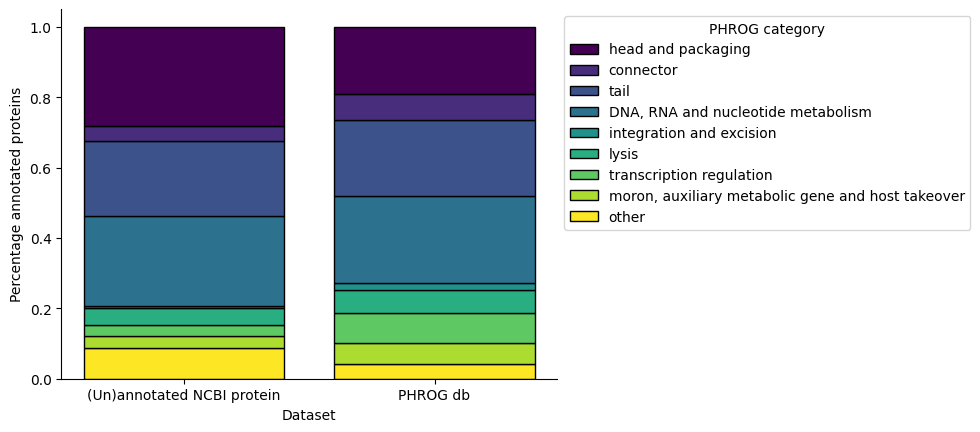

In [13]:
# let's represent this information visually, with a stacked bar chart, 
    # and for easier comparison, compare it to the proportional distribution of proteins annotated by PHROGS according to the article
    # https://academic.oup.com/view-large/283913665
# creating data dicts
our_data = {"head and packaging" : hap/count_ann_all, "connector": c/count_ann_all, "tail": t/count_ann_all,
            "DNA, RNA and nucleotide metabolism" : dranm/count_ann_all, "integration and excision" : iae/count_ann_all,
            "lysis" : l/count_ann_all, "transcription regulation": tr/count_ann_all, 
            "moron, auxiliary metabolic gene and host takeover" : mamgaht/count_ann_all, "other" : o/count_ann_all}
phrog_data = {"head and packaging" : 90413/475493, "connector": 35437/475493, "tail": 102372/475493,
            "DNA, RNA and nucleotide metabolism" : 117389/475493, "integration and excision" : 9839/475493,
            "lysis" : 31335/475493, "transcription regulation": 40892/475493, "moron, auxiliary metabolic gene and host takeover" : 27358/475493,
            "other" : 20458/475493}
# put data in long format in a dataframe
data_plot = pd.DataFrame({"PHROG category": list(our_data.keys()) + list(phrog_data.keys()),
                    "dataset": ["(Un)annotated NCBI protein"] * len(our_data.items()) + ["PHROG db"] * len(phrog_data.items()),
                    "percentage": list(our_data.values()) + list(phrog_data.values())})
# one liner to create a stacked bar chart
fig = plt.figure()
ax = sns.histplot(data_plot, x = "dataset", hue = "PHROG category" , weights = "percentage", multiple = "stack", palette = phrog_palette, shrink = 0.8, alpha = 1)
sns.despine()
ax.set_ylabel("Percentage annotated proteins")
ax.set_xlabel("Dataset")
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
fig.savefig(os.path.join(master_dir, "article_figures", "fig2", "PHROGcat_distribution_protein_pharokka.svg"), format = "svg", transparent = True, bbox_inches = "tight")

In [14]:
# let's have a look at the annotations found
annotations = pharokka_df[(pharokka_df["category"] != "unknown function")].groupby("annot").count().reset_index()[["annot", "ID"]]
annotations.rename(columns = {"annot" : "annotation", "ID" : "count"}, inplace = True)
annotations.sort_values("count", ascending = False)

,annotation,count
280,virion structural protein,253
255,tail fiber protein,112
53,HNH endonuclease,109
257,tail protein,82
256,tail length tape measure protein,63
...,...,...
125,dATP triphosphohydrolase,1
130,deoxyribonucleoside 5' monophosphate phosphatase,1
137,enoyl-CoA hydratase/carnithine racemase-like,1
141,exonuclease recombination-associated,1


<Axes: xlabel='count', ylabel='annotation'>

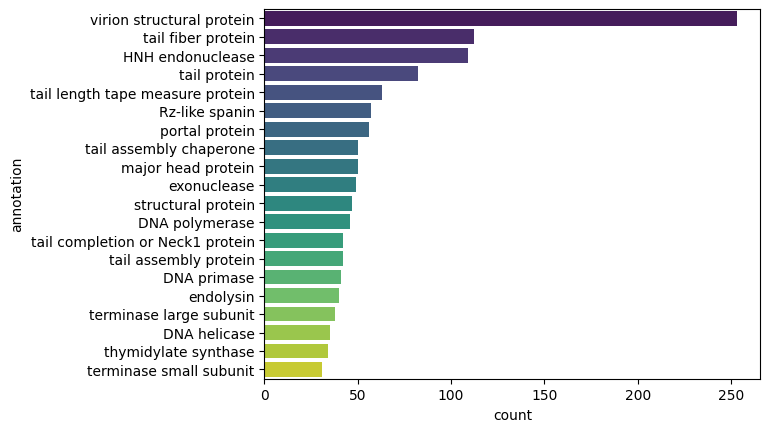

In [15]:
# let's represent this information visually
sns.barplot(data = annotations.sort_values("count", ascending = False)[0:20], y = "annotation", x = "count", hue = "annotation", palette = "viridis")

In [16]:
# let's correct this for cluster sizes
agg_df = cluster_protein_match.groupby("cluster_rep").size().reset_index(name = "counts")
pharokka_df["protein"] = pharokka_df["ID"].str.removeprefix("protein_").astype(int)
pharokka_df = agg_df.merge(pharokka_df, left_on = "cluster_rep", right_on = "protein")

In [17]:
# corrected for cluster size
# let's have a look at the annotations found
annotations_p = pharokka_df[(pharokka_df["category"] != "unknown function")].groupby("annot").sum().reset_index()[["annot", "counts"]]
annotations_p.rename(columns = {"annot" : "annotation", "counts" : "count"}, inplace = True)
annotations_p.sort_values("count", ascending = False)

,annotation,count
280,virion structural protein,1495
255,tail fiber protein,684
53,HNH endonuclease,321
213,portal protein,287
91,Rz-like spanin,247
...,...,...
147,head closure Hc2,1
48,Fe-S-cluster redox domain-containing,1
243,tRNA methyltransferase,1
244,tRNA splicing ligase,1


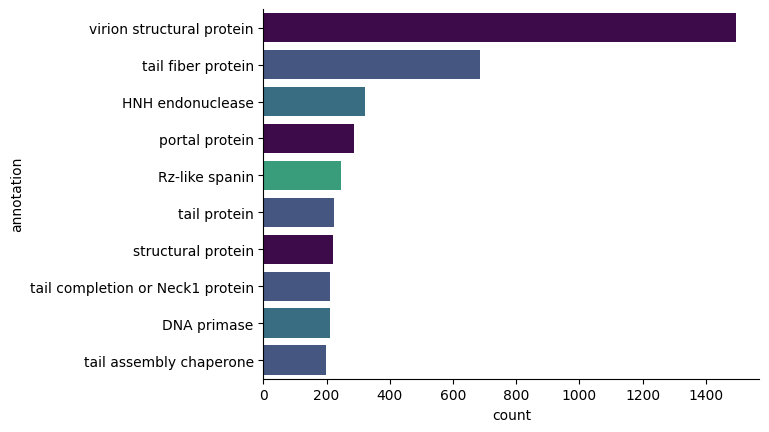

In [18]:
# let's now represent this visually, coloring annotations according to the PHROG category they belong to
sns.barplot(data = annotations_p.sort_values("count", ascending = False)[0:10], y = "annotation", x = "count", hue = "annotation", palette = 
            {"virion structural protein" : "#440154", "tail fiber protein" : "#3b528b", "HNH endonuclease": "#2c728e", 
            "portal protein" : "#440154", "Rz-like spanin" : "#28ae80", "tail protein" : "#3b528b", 
            "structural protein" :  "#440154", "tail completion or Neck1 protein" : "#3b528b", "DNA primase" : "#2c728e", "tail assembly chaperone" : "#3b528b"}) 
sns.despine()
plt.savefig(os.path.join(master_dir, "article_figures", "fig2",  "top10_annotations_protein_pharokka.svg"), format = "svg", transparent = True, bbox_inches = "tight")

##### Assessing potential confounders of annotatibility by Pharokka - cluster size

Let's have a look at whether there is a relationship between cluster size and whether or not Pharokka annotates a protein. A bigger cluster size would imply that the protein is more common, which might make it more likely to have been annotated in the past.

In [19]:
# are the proteins annotated by Pharokka special? Come from larger clusters?
agg_df["label"] = "unannotated"
agg_df.loc[agg_df["cluster_rep"].isin(ncbi_id_ann), "label"] = "annotated"
mannwhitneyu(agg_df[agg_df["label"] == "annotated"]["counts"], agg_df[agg_df["label"] == "unannotated"]["counts"], alternative = "greater")

MannwhitneyuResult(statistic=np.float64(11947828.0), pvalue=np.float64(3.3784523715509687e-21))

In [20]:
# average cluster sizes
ann_m_clusi = np.mean(agg_df[agg_df["label"] == "annotated"]["counts"])
ann_sd_clusi = np.std(agg_df[agg_df["label"] == "annotated"]["counts"])
unann_m_clusi = np.mean(agg_df[agg_df["label"] == "unannotated"]["counts"])
unann_sd_clusi = np.std(agg_df[agg_df["label"] == "unannotated"]["counts"])
print("The average annotated protein cluster contains", "{:.0f}".format(ann_m_clusi), "+-", "{:.0f}".format(ann_sd_clusi), "proteins.")
print("The average unannotated protein cluster contains", "{:.0f}".format(unann_m_clusi), "+-", "{:.0f}".format(unann_sd_clusi), "proteins.")

The average annotated protein cluster contains 4 +- 8 proteins.
The average unannotated protein cluster contains 3 +- 10 proteins.


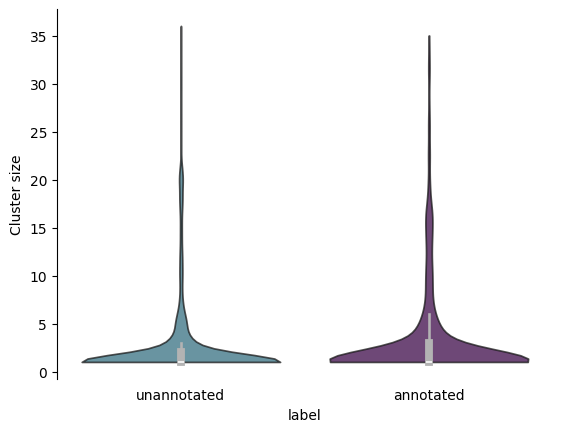

In [21]:
# let's now plot cluster size for all clusters, seperating annotated from unannotated proteins
vplot = sns.violinplot(data = agg_df[agg_df["counts"].between(agg_df["counts"].quantile(0.01), agg_df["counts"].quantile(.99))], x = "label", y = "counts", hue = "label", 
                       palette = ["#2a788e", "#440154"], inner_kws=dict(color=".7"), alpha = 0.75, cut = 0)
vplot.set_ylabel("Cluster size")
sns.despine(top = True, bottom = True, right = True)
vplot.tick_params(bottom=False) 
plt.savefig(os.path.join(master_dir, "article_figures", "fig2", "violinplot_clustersize_cluster_pharokka.svg"), format = "svg", transparent = True, bbox_inches = "tight")

##### Assessing potential confounders of annotatibility by Pharokka - protein size

Let's have a look at whether there is a relationship between protein size and whether or not Pharokka annotates a protein, like we saw before in the full NCBI protein dataset.

In [22]:
# let's also have a look at protein size
protein_data = pd.read_table(os.path.join(pipeline_search_dir, "a_input", "protein_overview", "protein_overview.txt"), names=["taxid_name", "ncbi_protein_id", "ncbi_protein_name", "ncbi_protein_length"])
protein_data = protein_data[protein_data["ncbi_protein_id"].isin(proteins_w_structure)]
protein_data["label"] = "unannotated"
protein_data.loc[protein_data["ncbi_protein_id"].isin(ncbi_id_ann), "label"] = "annotated"
mannwhitneyu(protein_data[protein_data["label"] == "annotated"]["ncbi_protein_length"], protein_data[protein_data["label"] == "unannotated"]["ncbi_protein_length"], alternative = "greater")

MannwhitneyuResult(statistic=np.float64(15116898.5), pvalue=np.float64(1.3962064850302225e-212))

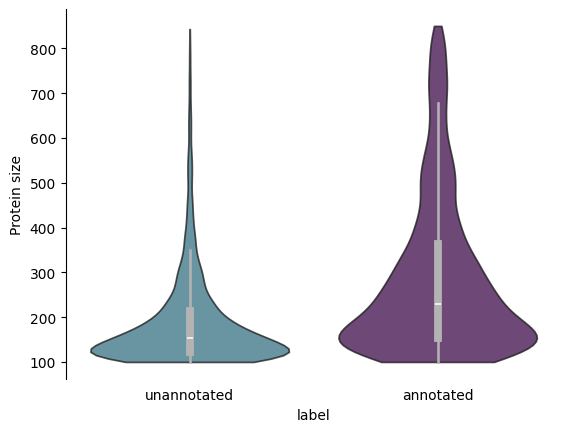

In [23]:
# let's now plot cluster size for all clusters, seperating annotated from unannotated proteins
vplot = sns.violinplot(data = protein_data, x = "label", y = "ncbi_protein_length", hue = "label", 
                         palette = ["#2a788e", "#440154"], inner_kws=dict(color=".7"), alpha = 0.75, cut = 0)
vplot.set_ylabel("Protein size")
sns.despine(top = True, bottom = True, right = True)
vplot.tick_params(bottom=False) 
plt.savefig(os.path.join(master_dir, "article_figures", "fig2",  "violinplot_proteinsize_cluster_pharokka.svg"), format = "svg", transparent = True, bbox_inches = "tight")

#### Goal 2 : Compare protein( structure)s to the Phold databases, using Phold

In the previous notebook, we have already searched for structural similarity of the predicted protein structures to the AlphaFold database and the PDB. However, phage specific databases are available, and implemented in Phold. As such, we will use Phold to assess similarity to these phage specific databases. 

Phold will be run in both the sequence- and structure-based approach. 

##### Sequence-based approach

For the sequence-based approach, we need to create input fasta files with our sequences, as well as job script files. For the multi-fasta files, we will simply group each structure prediction batch into 1 multi-fasta file, creating files of 500 proteins at a time. For the jobscript, we start from a script with all the details, except the pharokka_proteins command, as we have to fill out the reference to the input fasta file here. We will loop over the different batches and append these lines to the jobscript.

In [ ]:
os.mkdir(os.path.join(pipeline_annot_dir, "b_phold"))
os.mkdir(os.path.join(pipeline_annot_dir, "b_phold", "input_fastas"))

In [ ]:
# loop over structure batches
for i in range(0, 21):
    batch = f"batch_{i}"
    path_batch_results = os.path.join(struct_out_dir, batch, batch, "fastas")
    multifasta_file = os.path.join(pipeline_annot_dir, "b_phold", "input_fastas", f"proteins_{batch}.fasta")
    # go over results
    for protein_fasta in os.listdir(path_batch_results):
        ncbi_protein = protein_fasta.removesuffix(".fasta")
        # exclude proteins for which we have no AlphaFold predictions
        if ncbi_protein not in bug_ids:
            fasta_file = os.path.join(path_batch_results, f"{ncbi_protein}.fasta")
            with open(fasta_file, "r") as fasta: 
                with open(multifasta_file, "a") as multifasta: 
                    for line in fasta: 
                        if ">" in line:
                            line = line.replace(">", ">protein_")
                        multifasta.write(line)

On HPC, created conda environment 'phold_env' by using 'conda install -c conda-forge -c bioconda phold pytorch==cuda' on interactive GPU node, and installed databases in $VSC_DATA using 'phold install -d ./phold_dbs '. Now, let's create the jobscript:

In [ ]:
script_content_seq = '''#!/bin/bash
#SBATCH --cluster=wice --partition=gpu_a100
#SBATCH --nodes=1 --gpus-per-node=1 --ntasks=18
#SBATCH --time=06:00:00

cd $SLURM_SUBMIT_DIR

source /data/leuven/331/vsc33164/miniconda3/bin/activate
conda activate phold_env

phold_db="/data/leuven/331/vsc33164/phold_dbs"

'''

In [ ]:
for i in range(0, 21):
    batch = f"batch_{i}"
    script_content_seq +=  f"phold proteins-predict -i ./input_fastas/proteins_{batch}.fasta -d $phold_db -o ./output_predict_seq_{batch} -t 18 \n"
    script_content_seq +=  f"phold proteins-compare -i ./input_fastas/proteins_{batch}.fasta --predictions_dir ./output_predict_seq_{batch} -d $phold_db -o ./output_compare_seq_{batch} -t 18 \n"

In [ ]:
script_seq = os.path.join(pipeline_annot_dir, "b_phold", "phold_seq.slurm")
with open(script_seq, "w") as file:
    print(script_content_seq, file = file)

This can now  be submitted to the HPC.

##### Structure-based approach

To run Phold based on the structures, we can reuse the input fasta files with our sequences, but need to copy the relevant structure files (renaming them in the process, to match the fasta headers), as well as create adapted job script files. For the structure files, we will simply group each structure prediction batch into 1 folder, and rename the files while copying, creating directories of 500 proteins at a time. For the jobscript, we start from a script with all the details, except the pharokka_proteins command, as we have to fill out the reference to the input fasta file here. We will loop over the different batches and append these lines to the jobscript.

In [ ]:
# looping over batches
for i in range(0, 21):
    batch = f"batch_{i}"
    path_batch_fastas = os.path.join(struct_out_dir, batch, batch, "fastas")
    path_batch_results = os.path.join(struct_out_dir, batch, batch, "results")
    out_dir = os.path.join(pipeline_annot_dir, "b_phold", "input_structures", f"input_structures_{batch}")
    os.makedirs(out_dir)
    # go over results
    for protein_fasta in os.listdir(path_batch_results):
        ncbi_protein = protein_fasta.removesuffix(".fasta")
        ncbi_protein_int = int(ncbi_protein)
        # exclude proteins for which we have no AlphaFold predictions
        if ncbi_protein_int not in bug_ids:
            structure_path = os.path.join(path_batch_results, ncbi_protein)
            if ncbi_protein_int not in relaxation_failed_ids:
                shutil.copyfile(os.path.join(structure_path, f"{ncbi_protein}_relaxed.pdb"), os.path.join(out_dir, f"protein_{ncbi_protein}.pdb"))
            elif ncbi_protein_int in relaxation_failed_ids:
                for file in os.listdir(structure_path):
                    if "rank_1" in file:
                        shutil.copyfile(os.path.join(structure_path, file), os.path.join(out_dir, f"protein_{ncbi_protein}.pdb"))

In [ ]:
script_content_str = '''#!/bin/bash
#SBATCH --cluster=wice --partition=gpu_a100
#SBATCH --nodes=1 --gpus-per-node=1 --ntasks=18
#SBATCH --time=01:00:00

cd $SLURM_SUBMIT_DIR

source /data/leuven/331/vsc33164/miniconda3/bin/activate
conda activate phold_env

phold_db="/data/leuven/331/vsc33164/phold_dbs"

'''

In [ ]:
for i in range(0, 21):
    batch = f"batch_{i}"
    script_content_str +=  f"phold proteins-compare -i ./input_fastas/proteins_{batch}.fasta --structures --structure_dir ./input_structures/input_structures_{batch} -d $phold_db -o ./output_compare_str_{batch} -t 18 \n"

In [ ]:
script_str = os.path.join(pipeline_annot_dir, "b_phold", "phold_str.slurm")
with open(script_str, "w") as file:
    print(script_content_str, file=file)

This can also be submitted to the HPC.

In [24]:
phold_results_dir = os.path.join(os.path.join(os.environ["USERPROFILE"]), "Desktop", "phage_annotation_output", "5_phold") 

#### Goal 3: Assess which proteins are ammenable to annotation based on structure similarity

As we want to assess the efficacy of structure-based annotations that use FoldSeek, we are ultimately limited in annotation to those who at least have some structural similarity to one of our search databases. Let's investigate how many proteins have no FoldSeek hits, both to our databases, as well as to the Phold databases.  

In [25]:
# let's write some code for the FoldSeek output from our own searches first,in essence, all we have to check is the line count
def get_num_hits(b_dir, protein):
    # paths to different files
    aln_pdb_raw = os.path.join(b_dir, f"{protein}_foldseek_pdb_default.csv")
    aln_af50m_raw = os.path.join(b_dir, f"{protein}_foldseek_af50m_default.csv")
    # calculate hit count
    with open(aln_pdb_raw) as file:
        pdb_raw_count = sum(1 for _ in file) - 1
    with open(aln_af50m_raw) as file:
        af50m_raw_count = sum(1 for _ in file) - 1 
    return pdb_raw_count, af50m_raw_count

In [26]:
# aggregating phold - structure results
phold_structure_df = pd.DataFrame()
    # loop over batch
for i in range(0,21):
    batch = f"batch_{i}"
    batch_file = pd.read_csv(os.path.join(phold_results_dir, f"output_compare_str_{batch}", "phold_per_cds_predictions.tsv"), sep = "\t")
    phold_structure_df = pd.concat([batch_file, phold_structure_df], ignore_index = True) 

In [27]:
# aggregating phold - sequence results
phold_sequence_df = pd.DataFrame()
    # loop over batch
for i in range(0,21):
    batch = f"batch_{i}"
    batch_file = pd.read_csv(os.path.join(phold_results_dir, f"output_compare_seq_{batch}", "phold_per_cds_predictions.tsv"), sep = "\t")
    phold_sequence_df = pd.concat([batch_file, phold_sequence_df], ignore_index = True)

In [28]:
# let's also write a function to check whether a protein has shown structural similarity to any of the Phold databases
def get_bin_hit_phold(df, protein):
    subdf = df[df["cds_id"] == f"protein_{protein}"]
    if subdf["annotation_source"].values[0] == "foldseek":
        return True
    elif np.isnan(subdf["annotation_source"].values[0]):
        return False

In [29]:
 # results storage dict
protein_hits = {}
# apply function
for batch_index, protein_list in dict_batch_comp.items():
    for protein in protein_list:
        batch = f"batch_{batch_index}"
        path_batch = os.path.join(comp_out_dir, batch, batch)
        pdb_raw_count, af50m_raw_count = get_num_hits(path_batch, protein)
        phold_bin_str = get_bin_hit_phold(phold_structure_df, protein)
        phold_bin_seq = get_bin_hit_phold(phold_sequence_df, protein)
        protein_hits[protein] = pdb_raw_count, af50m_raw_count, phold_bin_str, phold_bin_seq
    print(f"Finished {batch} FoldSeek hit count analysis.")

Finished batch_0 FoldSeek hit count analysis.
Finished batch_1 FoldSeek hit count analysis.
Finished batch_2 FoldSeek hit count analysis.
Finished batch_3 FoldSeek hit count analysis.
Finished batch_4 FoldSeek hit count analysis.
Finished batch_5 FoldSeek hit count analysis.
Finished batch_6 FoldSeek hit count analysis.
Finished batch_7 FoldSeek hit count analysis.
Finished batch_8 FoldSeek hit count analysis.
Finished batch_9 FoldSeek hit count analysis.
Finished batch_10 FoldSeek hit count analysis.
Finished batch_11 FoldSeek hit count analysis.
Finished batch_12 FoldSeek hit count analysis.
Finished batch_13 FoldSeek hit count analysis.
Finished batch_14 FoldSeek hit count analysis.
Finished batch_15 FoldSeek hit count analysis.
Finished batch_16 FoldSeek hit count analysis.
Finished batch_17 FoldSeek hit count analysis.
Finished batch_18 FoldSeek hit count analysis.
Finished batch_19 FoldSeek hit count analysis.
Finished batch_20 FoldSeek hit count analysis.
Finished batch_21 FoldS

In [30]:
no_match_list = list()
no_match_str = list()
no_match_pdb = list()
no_match_afdb = list()
no_match_phold_seq = list()
no_match_phold_str = list()
for key, value in protein_hits.items():
    if value == (0, 0, False, False):
        no_match_list.append(key)   
    if value[0] == 0:
        no_match_pdb.append(key)
    if value[1] == 0:
        no_match_afdb.append(key)
    if value[2] == False:
        no_match_phold_str.append(key)
    if value[3] == False:
        no_match_phold_seq.append(key)
    if value[0] == 0 and value[1] == 0 and value[2] == False:
        no_match_str.append(key)

Now that we have calculated and extracted the structural similarity, let's summarize our findings:

In [31]:
# General stats:
print(f"The PDB did not display any significant structural similarity to {len(no_match_pdb)} clusters (thus matching {len(proteins_w_structure)-len(no_match_pdb)} structures).")
print(f"The AlphaFold/UniProt50-minimal database did not display any significant structural similarity to {len(no_match_afdb)} clusters (thus matching {len(proteins_w_structure)-len(no_match_afdb)} structures).")
print(f"The Phold database did not display any significant structural similarity (based on 3Di tokens) to {len(no_match_phold_seq)} clusters (thus matching {len(proteins_w_structure)-len(no_match_phold_seq)} structures).")
print(f"The Phold database did not display any significant structural similarity (based on structures) to {len(no_match_phold_str)} clusters (thus matching {len(proteins_w_structure)-len(no_match_phold_str)} structures).")
print(f"{len(no_match_list)} clusters did not match any of the databases, meaning {len(proteins_w_structure)-len(no_match_list)} proteins matched at least 1.")

The PDB did not display any significant structural similarity to 8194 clusters (thus matching 2287 structures).
The AlphaFold/UniProt50-minimal database did not display any significant structural similarity to 4304 clusters (thus matching 6177 structures).
The Phold database did not display any significant structural similarity (based on 3Di tokens) to 3680 clusters (thus matching 6801 structures).
The Phold database did not display any significant structural similarity (based on structures) to 2645 clusters (thus matching 7836 structures).
2276 clusters did not match any of the databases, meaning 8205 proteins matched at least 1.


In [32]:
# reversing the lists, and selecting those who did match, and calculating the overlap
match_afdb = [prot for prot in proteins_w_structure if prot not in no_match_afdb]
match_phold_str = [prot for prot in proteins_w_structure if prot not in no_match_phold_str]
match_pdb = [prot for prot in proteins_w_structure if prot not in no_match_pdb]
intersection = set(match_afdb) & set(match_phold_str) & set(match_pdb)
print(f"There are {len(intersection)} proteins that match to all three databases.")

There are 2242 proteins that match to all three databases.


In [33]:
# how many proteins are in those clusters?
match_str = [prot for prot in proteins_w_structure if prot not in no_match_str]
total_count = agg_df[agg_df["cluster_rep"].isin(match_str)]["counts"].sum()/agg_df[agg_df["cluster_rep"].isin(proteins_w_structure)]["counts"].sum()
total_count_f = "{:.2f}".format(total_count*100)
print(f"{total_count_f}% of all proteins match to at least one structure database.")

90.89% of all proteins match to at least one structure database.


##### Correcting for Pharokka annotated proteins

As we've shown before, not all proteins in our dataset actually need protein structure information to get annotated. Let's remove these proteins, to calculate more accurate metrics for the scale of our structure-informed annotation methods.

In [34]:
# correcting these numbers for those annotated by Pharokka
match_afdb_corr = [prot for prot in match_afdb if prot not in ncbi_id_ann]
match_phold_str_corr = [prot for prot in match_phold_str if prot not in ncbi_id_ann]
match_pdb_corr = [prot for prot in match_pdb if prot not in ncbi_id_ann]
# General stats:
print(f"The PDB displayed significant structural similarity to {len(match_pdb_corr)} clusters.")
print(f"The AlphaFold/UniProt50-minimal database displayed significant structural similarity to {len(match_afdb_corr)} clusters.")
print(f"The Phold database displayed significant structural similarity (based on structures) to {len(match_phold_str_corr)} clusters.")

The PDB displayed significant structural similarity to 698 clusters.
The AlphaFold/UniProt50-minimal database displayed significant structural similarity to 3578 clusters.
The Phold database displayed significant structural similarity (based on structures) to 5030 clusters.


In [35]:
# how many proteins are in those clusters?
match_str_corr = [prot for prot in match_str if prot not in ncbi_id_ann]
all_rep_corr = [prot for prot in proteins_w_structure if prot not in ncbi_id_ann]
total_count_corr = agg_df[agg_df["cluster_rep"].isin(match_str_corr)]["counts"].sum()/agg_df[agg_df["cluster_rep"].isin(all_rep_corr)]["counts"].sum()
total_count_corr_f = "{:.2f}".format(total_count_corr*100)
print(f"{total_count_corr_f}% of all remaining unannotated proteins match to at least one structure database.")

87.17% of all remaining unannotated proteins match to at least one structure database.


In [36]:
# which percentage of clusters is this?
per_clu_corr = len(agg_df[agg_df["cluster_rep"].isin(match_str_corr)])/len(agg_df[agg_df["cluster_rep"].isin(all_rep_corr)])
per_clu_corr_f = "{:.2f}".format(per_clu_corr*100)
print(f"{per_clu_corr_f}% of all remaining unannotated clusters match to at least one structure database.")

69.08% of all remaining unannotated clusters match to at least one structure database.


Are the different databases complementary to each other, or could one easily just choose one over the other? 

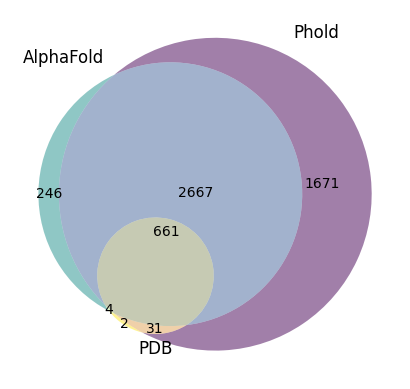

In [37]:
# visually in a Venn diagam: quite some complementarity
set1 = set(match_afdb_corr)
set2 = set(match_phold_str_corr)
set3 = set(match_pdb_corr)

venn3([set1, set2, set3], ["AlphaFold", "Phold", "PDB"], set_colors=["#21918c", "#440154", "#fde725"], alpha = 0.5)

plt.show()

C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

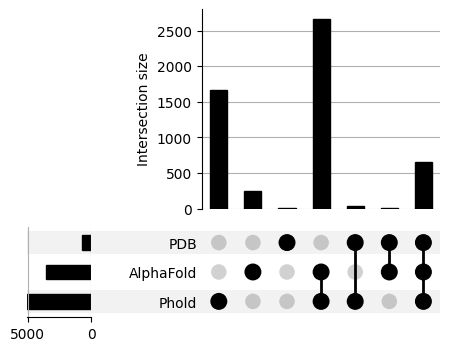

In [39]:
# through an upset plot
set_names = ["AlphaFold", "Phold", "PDB"]
all_elems = set(match_afdb_corr).union(set(match_phold_str_corr)).union(set(match_pdb_corr))
df = pd.DataFrame([[e in set(match_afdb_corr), e in set(match_phold_str_corr), e in set(match_pdb_corr)] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')
plt.savefig(os.path.join(master_dir, "article_figures", "fig4", "upset_complementarity_searchdb_trulyunann_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

##### Assessing potential confounders of structural similarity to databases - cluster size

Let's have a look at whether there is a relationship between cluster size and whether or not a protein displays significant structural similarity to any of the search databases. A bigger cluster size would imply that the protein is more common, which might make it more likely to have been included in any of these search databases.

In [40]:
# are clusters not matched to the database special? - smaller cluster size, smaller MSA during AF, lower quality?
agg_df["matching_structure"] = "no"
agg_df.loc[agg_df["cluster_rep"].isin(match_str_corr), "matching_structure"] = "yes"
mannwhitneyu(agg_df[agg_df["matching_structure"]  == "yes"]["counts"], agg_df[agg_df["matching_structure"]  == "no"]["counts"], alternative = "greater")

MannwhitneyuResult(statistic=np.float64(15008244.0), pvalue=np.float64(1.5881401282057822e-21))

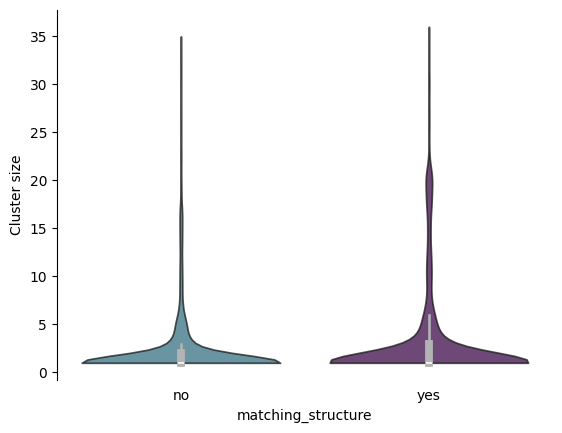

In [41]:
# let's now plot cluster size for all clusters, seperating proteins with database matches from those without
vplot = sns.violinplot(data = agg_df[agg_df["counts"].between(agg_df["counts"].quantile(0.01), agg_df["counts"].quantile(.99))], x = "matching_structure", y = "counts", 
                       hue = "matching_structure", palette = ["#440154", "#2a788e"], inner_kws=dict(color=".7"), alpha = 0.75, cut = 0,
                       order = ["no", "yes"])
vplot.set_ylabel("Cluster size")
sns.despine(top = True, bottom = True, right = True)
vplot.tick_params(bottom=False) 
plt.savefig(os.path.join(master_dir, "article_figures", "fig4", "violinplot_clustersize_matching_structure_trulyunann_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

##### Assessing potential confounders of structural similarity to databases - MSA depth

Let's have a look at whether there is a relationship between MSA depth and whether or not a protein displays significant structural similarity to any of the search databases. MSA depth, like cluster size, is related to how genetically divergent a sequence is from what's in databases, and hence could be correlated to whether or not we find similar proteins in structure databases.

In [42]:
# reading in the data
pred_qual_df = pd.read_csv(os.path.join(pipeline_search_dir, "b_structure", "structure_prediction", "prediction_metrics.tsv"), sep = "\t")
# adding in the information on structure matches
pred_qual_df["matching_structure"] = "no"
pred_qual_df.loc[pred_qual_df["protein"].isin(match_str_corr), "matching_structure"] = "yes"

In [43]:
# let's test whether proteins matching to structure databases have larger MSAs
mannwhitneyu(pred_qual_df[pred_qual_df["matching_structure"]  == "yes"]["max MSA depth"], pred_qual_df[pred_qual_df["matching_structure"]  == "no"]["max MSA depth"], alternative = "greater")

MannwhitneyuResult(statistic=np.float64(14796694.5), pvalue=np.float64(2.8182901049839475e-12))

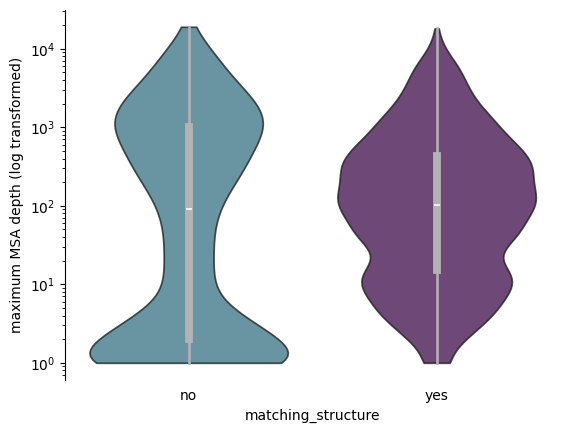

In [44]:
# let's now plot MSA depth for all clusters, seperating proteins with database matches from those without
vplot = sns.violinplot(data = pred_qual_df, y = "max MSA depth", x = "matching_structure",
                       hue = "matching_structure", palette = ["#2a788e", "#440154"], inner_kws=dict(color=".7"), alpha = 0.75, cut = 0,
                       order = ["no", "yes"], log_scale = True)
vplot.set_ylabel("maximum MSA depth (log transformed)")
sns.despine(top = True, bottom = True, right = True)
vplot.tick_params(bottom=False) 
plt.savefig(os.path.join(master_dir, "article_figures", "fig4", "violinplot_MSAdepth_matching_structure_trulyunann_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

##### Assessing potential confounders of structural similarity to databases - pLDDT

Let's have a look at whether there is a relationship between pLDDT and whether or not a protein displays significant structural similarity to any of the search databases. pLDDT is a metric for model quality, and it could be possible that better predicted structures make it easier to identify structural similarity in search databases.

In [45]:
# let's test whether proteins matching to structure databases have better pLDDT scores
mannwhitneyu(pred_qual_df[pred_qual_df["matching_structure"]  == "yes"]["avg pLDDT_y"], pred_qual_df[pred_qual_df["matching_structure"]  == "no"]["avg pLDDT_y"], alternative = "greater")

MannwhitneyuResult(statistic=np.float64(15684528.0), pvalue=np.float64(8.600838593225996e-37))

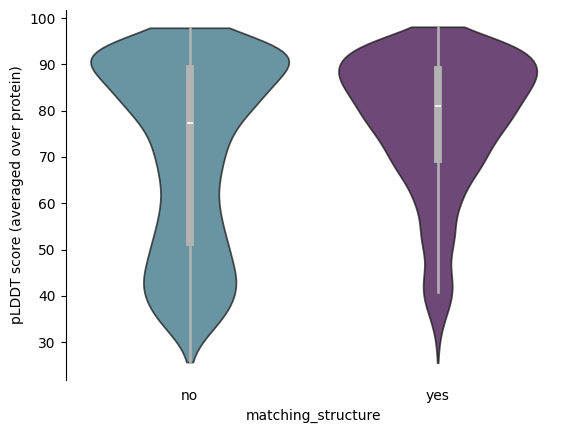

In [46]:
# let's now plot pLDDT scores for all clusters, seperating proteins with database matches from those without
vplot = sns.violinplot(data = pred_qual_df, y = "avg pLDDT_y", x = "matching_structure",
                       hue = "matching_structure", palette = ["#2a788e", "#440154"], inner_kws=dict(color=".7"), alpha = 0.75, cut = 0,
                       order = ["no", "yes"])
vplot.set_ylabel("pLDDT score (averaged over protein)")
sns.despine(top = True, bottom = True, right = True)
vplot.tick_params(bottom=False) 
plt.savefig(os.path.join(master_dir, "article_figures", "fig4", "violinplot_pLDDT_matching_structure_trulyunann_cluster.svg"), format = "svg", transparent = True, bbox_inches = "tight")

#### Goal 4 : Filter the FoldSeek files for easier function annotation

To reduce the number of FoldSeek hits to consider during annotation, and most importantly, retain those that are most likely of similar function as the protein at hand, we will use the following set of filters:
- probability of our protein and its match to belong to the same SCOP class: > 50%
- quality of the alignment: alignment lDDT > 50% (based on visual inspection of alignments)
- quality of the aligned region of input protein: average plDDT of aligned region > 70 (standard AlphaFold cut-off)

We also apply the same correction on the E-value as before (filter at 1E-3).
  
In order to do so, we write functions to extract these features, and then filter based on these values.

In [47]:
# define a PDB parser
p = PDBParser()

In [48]:
# function for calculating average pLDDT of aligned region on FoldSeek results
def get_pLDDT(structure, start, stop):
    for model in structure:
        for chain in model:
            count_residue = 0
            pLDDT_chain = 0
            for residue in chain:
                if residue.id[1] in range(start,stop+1):
                    count_residue += 1
                    count_atom = 0
                    pLDDT_atom = 0
                    for atom in residue:
                        count_atom += 1
                        pLDDT_atom += atom.get_bfactor()
                    pLDDT_res = round(pLDDT_atom/count_atom,2)
                    pLDDT_chain += pLDDT_res
            pLDDT_range = round(pLDDT_chain/count_residue,2)
    return pLDDT_range

In [ ]:
# loop through batches, then through proteins
for index_batch, batch in dict_batch_comp.items():
    batch_dir = os.path.join(comp_out_dir, f"batch_{index_batch}", f"batch_{index_batch}")
    os.makedirs(batch_out_dir)
    for protein in batch:
        # get protein structure from AlphaFold
        if protein not in relaxation_failed_ids:
            structure = p.get_structure(protein, os.path.join(batch_dir, "{0}_relaxed.pdb".format(protein)))
        if protein in relaxation_failed_ids:
            structure = p.get_structure(protein, os.path.join(batch_dir, "{0}_best.pdb".format(protein)))
        # filtering hits against AF50m database
            # reading in the data
        data_af50m = pd.read_table(os.path.join(batch_dir, "{0}_aln_af50m.txt".format(protein)), header=None, names=["query","target","fident","alnlen","mismatch","gapopen","qstart","qend","tstart","tend","evalue","bits","prob","lddt","lddtfull"])
            # adding AlphaFold quality metrics - pLDDT of aligned region query
        for i in range(0,len(data_af50m)):
            data_af50m.at[i,"pLDDT_qAln"] = get_pLDDT(structure, data_af50m.at[i,"qstart"],data_af50m.at[i,"qend"])
            # filtering based on FoldSeek parameters & AF model accuracy
        data_af50m_filtered = data_af50m
        if len(data_af50m_filtered) != 0:
            data_af50m_filtered = data_af50m_filtered[(data_af50m_filtered["prob"] > 0.5) & (data_af50m_filtered["evalue"] < 1e-3) & (data_af50m_filtered["lddt"] >= 0.5) & (data_af50m_filtered["pLDDT_qAln"] >= 0.7)]
        data_af50m_filtered = data_af50m_filtered.reset_index()
            # store filtered FoldSeek results
        data_af50m_filtered.to_csv(os.path.join(batch_dir, f"{protein}_foldseek_af50m_filtered.csv"), index=False)     
        # filtering hits against PDB database
            # reading in the data
        data_pdb = pd.read_table(os.path.join(batch_dir, "{0}_aln_pdb.txt".format(protein)), header=None, names=["query","target","fident","alnlen","mismatch","gapopen","qstart","qend","tstart","tend","evalue","bits","prob","lddt","lddtfull"])
            # adding AlphaFold quality metrics - pLDDT of aligned region query
        for i in range(0,len(data_pdb)):
            data_pdb.at[i,"pLDDT_qAln"] = get_pLDDT(structure, data_pdb.at[i,"qstart"],data_pdb.at[i,"qend"])
            # filtering based on FoldSeek parameters & AF model accuracy
        data_pdb_filtered = data_pdb
        if len(data_pdb_filtered) != 0:
            data_pdb_filtered = data_pdb_filtered[(data_pdb_filtered["prob"] > 0.5) & (data_pdb_filtered["evalue"] < 1e-3) & (data_pdb_filtered["lddt"] >= 0.5) & (data_pdb_filtered["pLDDT_qAln"] >= 0.7)]
        data_pdb_filtered = data_pdb_filtered.reset_index()
            # store filtered FoldSeek results
        data_pdb_filtered.to_csv(os.path.join(batch_dir, f"{protein}_foldseek_pdb_filtered.csv"), index=False) 

In [49]:
# let's write some code for the FoldSeek output from our own searches first,in essence, all we have to check is the line count
def get_num_hits_filtered(b_dir, protein):
    # paths to different files
    aln_pdb_fil = os.path.join(b_dir, f"{protein}_foldseek_pdb_filtered.csv")
    aln_af50m_fil = os.path.join(b_dir, f"{protein}_foldseek_af50m_filtered.csv")
    # calculate hit count
    with open(aln_pdb_fil) as file:
        pdb_fil_count = sum(1 for _ in file) - 1
    with open(aln_af50m_fil) as file:
        af50m_fil_count = sum(1 for _ in file) - 1 
    return pdb_fil_count, af50m_fil_count

In [50]:
 # results storage dict
protein_hits_fil = {}
# apply function
for batch_index, protein_list in dict_batch_comp.items():
    for protein in protein_list:
        batch = f"batch_{batch_index}"
        path_batch = os.path.join(comp_out_dir, batch, batch)
        pdb_fil_count, af50m_fil_count = get_num_hits_filtered(path_batch, protein)
        protein_hits_fil[protein] = pdb_fil_count, af50m_fil_count
    print(f"Finished {batch} FoldSeek filtered hit count analysis.")

Finished batch_0 FoldSeek filtered hit count analysis.
Finished batch_1 FoldSeek filtered hit count analysis.
Finished batch_2 FoldSeek filtered hit count analysis.
Finished batch_3 FoldSeek filtered hit count analysis.
Finished batch_4 FoldSeek filtered hit count analysis.
Finished batch_5 FoldSeek filtered hit count analysis.
Finished batch_6 FoldSeek filtered hit count analysis.
Finished batch_7 FoldSeek filtered hit count analysis.
Finished batch_8 FoldSeek filtered hit count analysis.
Finished batch_9 FoldSeek filtered hit count analysis.
Finished batch_10 FoldSeek filtered hit count analysis.
Finished batch_11 FoldSeek filtered hit count analysis.
Finished batch_12 FoldSeek filtered hit count analysis.
Finished batch_13 FoldSeek filtered hit count analysis.
Finished batch_14 FoldSeek filtered hit count analysis.
Finished batch_15 FoldSeek filtered hit count analysis.
Finished batch_16 FoldSeek filtered hit count analysis.
Finished batch_17 FoldSeek filtered hit count analysis.
Fi

In [51]:
no_match_fil_list = list()
no_match_str_fil = list()
no_match_pdb_fil = list()
no_match_afdb_fil = list()
for key, value in protein_hits_fil.items():
    if value == (0, 0):
        if key in no_match_phold_str:
            no_match_str_fil.append(key)   
            if key in no_match_phold_seq:
                no_match_fil_list.append(key)
    if value[0] == 0:
        no_match_pdb_fil.append(key)
    if value[1] == 0:
        no_match_afdb_fil.append(key)

Now that's extracted, let's look at some stats:

In [52]:
# General stats:
print(f"The PDB did not display any significant structural similarity (after filtering) to {len(no_match_pdb_fil)} clusters (thus matching {len(proteins_w_structure)-len(no_match_pdb_fil)} structures).")
print(f"The AlphaFold/UniProt50-minimal database did not display any significant structural similarity (after filtering) to {len(no_match_afdb_fil)} clusters (thus matching {len(proteins_w_structure)-len(no_match_afdb_fil)} structures).")
print(f"{len(no_match_fil_list)} clusters did not match any of the databases (after filtering), meaning {len(proteins_w_structure)-len(no_match_fil_list)} proteins matched at least 1.")

The PDB did not display any significant structural similarity (after filtering) to 8636 clusters (thus matching 1845 structures).
The AlphaFold/UniProt50-minimal database did not display any significant structural similarity (after filtering) to 4446 clusters (thus matching 6035 structures).
2298 clusters did not match any of the databases (after filtering), meaning 8183 proteins matched at least 1.


In [53]:
# reversing the lists, and selecting those who did match, and calculating the overlap
match_afdb_fil = [prot for prot in proteins_w_structure if prot not in no_match_afdb_fil]
match_pdb_fil = [prot for prot in proteins_w_structure if prot not in no_match_pdb_fil]
intersection_fil = set(match_afdb_fil) & set(match_phold_str) & set(match_pdb_fil)
print(f"There are {len(intersection_fil)} proteins that match to all three databases (after filtering).")

There are 1802 proteins that match to all three databases (after filtering).


In [54]:
# how many proteins are in those clusters?
match_str_fil = [prot for prot in proteins_w_structure if prot not in no_match_str_fil]
total_count_fil = agg_df[agg_df["cluster_rep"].isin(match_str_fil)]["counts"].sum()/agg_df[agg_df["cluster_rep"].isin(proteins_w_structure)]["counts"].sum()
total_count_fil_f = "{:.2f}".format(total_count_fil*100)
print(f"{total_count_fil_f}% of all proteins match to at least one structure database (after filtering).")

90.80% of all proteins match to at least one structure database (after filtering).


##### Correcting for Pharokka annotated proteins

As we've shown before, not all proteins in our dataset actually need protein structure information to get annotated. Let's remove these proteins, to calculate more accurate metrics for the scale of our structure-informed annotation methods.

In [55]:
# correcting these numbers for those annotated by Pharokka
match_afdb_corr_fil = [prot for prot in match_afdb_fil if prot not in ncbi_id_ann]
match_pdb_corr_fil = [prot for prot in match_pdb_fil if prot not in ncbi_id_ann]
# General stats:
print(f"The PDB displayed significant structural similarity to {len(match_pdb_corr_fil)} clusters (after filtering).")
print(f"The AlphaFold/UniProt50-minimal database displayed significant structural similarity to {len(match_afdb_corr_fil)} clusters (after filtering).")

The PDB displayed significant structural similarity to 508 clusters (after filtering).
The AlphaFold/UniProt50-minimal database displayed significant structural similarity to 3458 clusters (after filtering).


In [56]:
# how many proteins are in those clusters?
match_str_corr_fil = [prot for prot in match_str_fil if prot not in ncbi_id_ann]
total_count_corr_fil = agg_df[agg_df["cluster_rep"].isin(match_str_corr_fil)]["counts"].sum()/agg_df[agg_df["cluster_rep"].isin(all_rep_corr)]["counts"].sum()
total_count_corr_fil_f = "{:.2f}".format(total_count_corr_fil*100)
print(f"{total_count_corr_fil_f}% of all remaining unannotated proteins match to at least one structure database.")

87.04% of all remaining unannotated proteins match to at least one structure database.


In [57]:
# which percentage of clusters is this?
per_clu_corr_fil = len(agg_df[agg_df["cluster_rep"].isin(match_str_corr_fil)])/len(agg_df[agg_df["cluster_rep"].isin(all_rep_corr)])
per_clu_corr_fil_f = "{:.2f}".format(per_clu_corr_fil*100)
print(f"{per_clu_corr_fil_f}% of all remaining unannotated clusters match to at least one structure database.")

68.75% of all remaining unannotated clusters match to at least one structure database.


Is complementarity the same, or more exagerated now? Bit more in favor of Phold now, but overall, very small effect. 

C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\hanne\miniforge3\envs\ffal_annotate\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

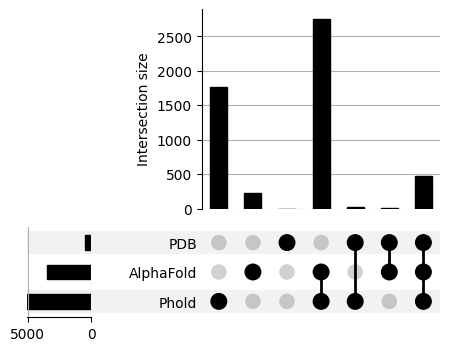

In [58]:
# through an upset plot
set_names = ["AlphaFold", "Phold", "PDB"]
all_elems = set(match_afdb_corr_fil).union(set(match_phold_str_corr)).union(set(match_pdb_corr_fil))
df = pd.DataFrame([[e in set(match_afdb_corr_fil), e in set(match_phold_str_corr), e in set(match_pdb_corr_fil)] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')

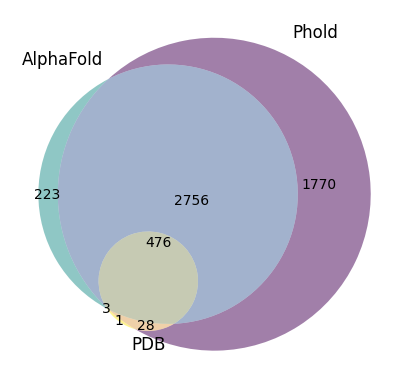

In [59]:
# visually in a Venn diagam: quite some complementarity
set1 = set(match_afdb_corr_fil)
set2 = set(match_phold_str_corr)
set3 = set(match_pdb_corr_fil)

venn3([set1, set2, set3], ["AlphaFold", "Phold", "PDB"], set_colors=["#21918c", "#440154", "#fde725"], alpha = 0.5)

plt.show()

##### How many hits did we filter out?

As we've shown, there is hardly any difference in which proteins could be annotated, still reaching 83% of all remaining unannotated proteins (although perhaps a bit more dependent on the Phold results). However, the goal was not to reduce the amount of proteins we could annotate, but rather reduce the amount of uninformative hits. Let's see if the number of hits did indeed change, for the proteins which still have hits. 

In [60]:
num_hits_pdb = list()
num_hits_afdb = list()
num_hits_pdb_fil = list()
num_hits_afdb_fil = list()
for key, value in protein_hits.items():
    if value[0] != 0:
        num_hits_pdb.append(value)
    if value[1] != 0:
        num_hits_afdb.append(value)
for key, value in protein_hits_fil.items():
    if value[0] != 0:
        num_hits_pdb_fil.append(value)
    if value[1] != 0:
        num_hits_afdb_fil.append(value)

In [61]:
print(f"Before filtering, a total of {np.sum(num_hits_pdb)} hits was found against the PDB. After filtering, the total count was {np.sum(num_hits_pdb_fil)}.")

Before filtering, a total of 1483753 hits was found against the PDB. After filtering, the total count was 950210.


In [62]:
print(f"Before filtering, a total of {np.sum(num_hits_afdb)} hits was found against the AlphaFold database. After filtering, the total count was {np.sum(num_hits_afdb_fil)}.")

Before filtering, a total of 1788261 hits was found against the PDB. After filtering, the total count was 1283164.
